## Project: Yelp Review Analysis

**By:** Amanpreet Kaur

**Course:** LING 0571*COMPUTATIONAL CORPUS LING*

In [4]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk import *
import re

## Load data

In [5]:
# business datas
data_business = []
with open('./yelp_academic_dataset_business.json') as f:
    for line in f:
        data_business.append(json.loads(line))

# reviews data
data_reviews = []
with open('./yelp_academic_dataset_review.json') as f:
    for line in f:
        data_reviews.append(json.loads(line))        

# load dataset in dataframe
df_biz=pd.DataFrame(data_business) 
df_rev=pd.DataFrame(data_reviews)        

## Data preparation

In [6]:
# step1: Taking necessary columns from entire dataset
df_biz=df_biz[['business_id','state']]
df_rev=df_rev[['business_id','date', 'stars', 'text']]

In [7]:
# including following states - CA(California), NY (NewYork), FL (Florida), CO (Colorado), IL (Illinois)
states=['CA', 'FL','IL', 'CO', 'NY']

# Step2: dropping remaing states by setting them None
df_biz['state'] = df_biz['state'].apply(lambda x: x if x in states else None)
df_biz=df_biz.dropna()

In [8]:
# Step3: merging business an reviews data 
df=pd.merge(df_rev, df_biz, on='business_id',sort=True)

In [9]:
# Step4: adding year column for data
df['year']=df['date'].apply(lambda x: x[:4])

In [10]:
df.head(4)

,business_id,date,stars,text,state,year
0,-05uZNVbb8DhFweTEOoDVg,2016-07-05,2,To much bread! Ladies are rude and drive throu...,IL,2016
1,-05uZNVbb8DhFweTEOoDVg,2016-06-15,3,Brand new so everything looked great and food ...,IL,2016
2,-05uZNVbb8DhFweTEOoDVg,2016-07-28,1,I would rather go to the older subway then the...,IL,2016
3,-1TUzO4XCmOeqi9eAGeDWA,2016-08-29,5,Love a mechanic that gets a minor job done in ...,IL,2016


In [11]:
# writing the cleaned data for further processing
df.to_csv("data_cleaned.csv")

## Data cleaning
- Removing Null characters
- Removing punctuations and numbers from text reviews
- Lower casing words
- Tokenize the reviews
- Note: We are not putting words in their root form as we want to perform linguistic analysis

In [12]:
# Step 5 (Data gathering): Generating text corpus
def combine_text(data):
    text=[]
    data['text'].apply(lambda x: text.append(x))
    return " ".join(text)

def gen_cleaned_data(df):
    cleaned_data=list()
    # For each state combine reviews for each given year and collect in a dataframe
    for s in list(df.state.unique()):
        years=df[df.state==s].year.unique()
        for y in years:
            reviews=combine_text(df[(df.state==s) & (df.year==y)])
            cleaned_data.append({"state":s, "year":y, "review":reviews})
    return cleaned_data

# generating the corpus list
corpus=gen_cleaned_data(df)
# loading the combined 
cleaned=pd.DataFrame(corpus)
# sorting the valus
cleaned.sort_values(['state','year'],ascending=[1,1],inplace=True)
# resetting index
cleaned.reset_index(drop=True,inplace=True)

In [13]:
#check for null characters
cleaned.isnull().sum()

review    0
state     0
year      0
dtype: int64

In [14]:
# convert lowercase
cleaned['review']=cleaned['review'].apply(lambda x: x.lower())

In [15]:
# remove punctuations
cleaned['review'] = cleaned['review'].apply(lambda x: re.sub(r'[^a-zA-z\s]', ' ', x))

In [16]:
# tokenize the sentences
cleaned['review_token']=cleaned['review'].apply(lambda x: nltk.word_tokenize(x))

## Task 1: Text Corpus Analysis
- Lexical Diversity
- Total unique words
- Word Frequency Analysis (with stop words)
- Word Frequency Analysis (without stop words)
- Complex words (words length > 5)
- Part of Speech Tagging

### Visualizations

In [47]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Matplotlib config
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')
plt.rcParams["figure.figsize"] = (16,8)

#### Line Graph

In [64]:
# plotting line Plot
def gen_bar_graph(year, state1, state2,state3,title='Lexical Diversity'):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(year, state1, label='$CA - California', color='g')
    ax.plot(year, state2, label='$NY - New York', color='orange')
    ax.plot(year, state3, label='$CO - Colorado', color='b')
    plt.xlabel('Year')
    plt.ylabel(title)
    plt.title('Comparision of NY vs CA')
    ax.legend()
    #plt.show()

#### Word Cloud

In [19]:
# plotting word cloud
def gen_word_cloud(text):
    # Start with one review:
    text = " ".join([i[0] for i in text])
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Bar Graph

In [20]:
# plotting bar graph
def plot_bar_graph(year, words):
    # this is for plotting purpose
    index = np.arange(len(year))
    label = year
    plt.bar(index, words)
    plt.xlabel('Years', fontsize=10)
    plt.ylabel('Unique Word Count', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Variation of text richness over years')
    plt.show()

#### 1. Calculating lexical diversity

In [21]:
cleaned['lexical_diversity']=cleaned['review_token'].apply(lambda x: round((len(set(x))/len(x))*100,2))

In [69]:
len(CO), len(CA), len(NY)

(10, 9, 9)

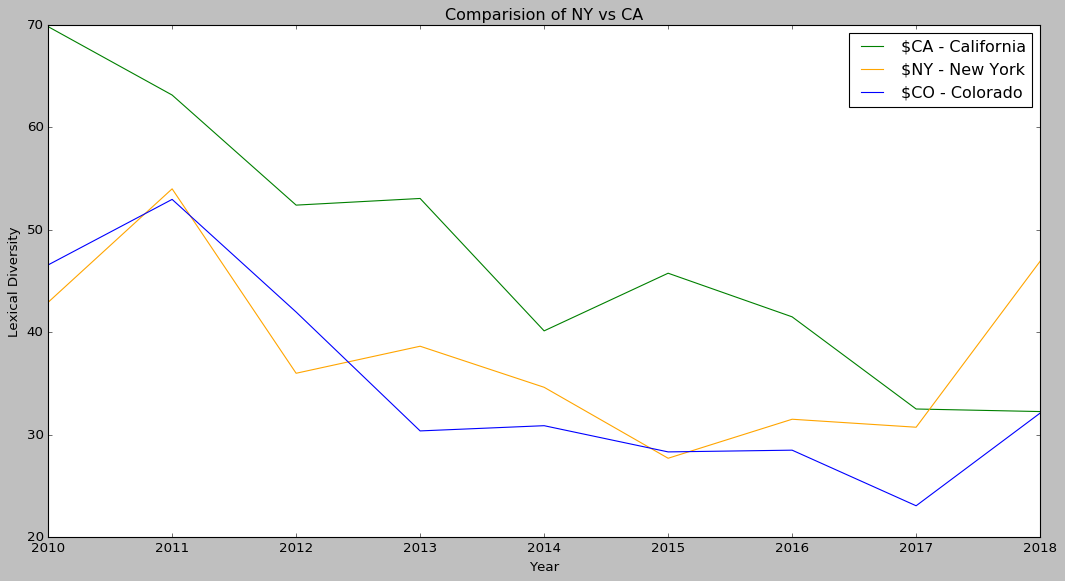

In [70]:
year = cleaned[cleaned.state=='CA'].year.tolist()
CA = cleaned[cleaned.state=='CA'].lexical_diversity.tolist()
NY = cleaned[cleaned.state=='NY'].lexical_diversity.tolist()[1:]
CO = cleaned[cleaned.state=='CO'].lexical_diversity.tolist()[2:]
# generating the graph for each 
gen_bar_graph(year,CA, NY, CO)

#### 2. Words Analysis

In [23]:
# Total Words count
cleaned['total_word_count']=cleaned['review_token'].apply(lambda x: len(x))

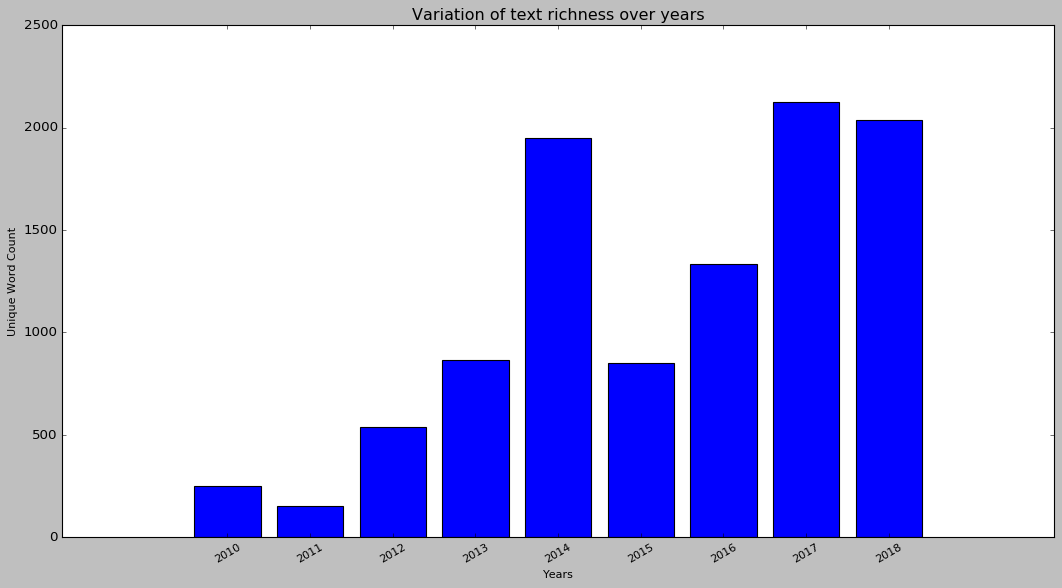

In [49]:
plot_bar_graph(cleaned[cleaned.state=='CA'].year.tolist(), cleaned[cleaned.state=='CA'].total_word_count.tolist())

In [25]:
# Unique words count
cleaned['unique_word_count']=cleaned['review_token'].apply(lambda x: len(set(x)))

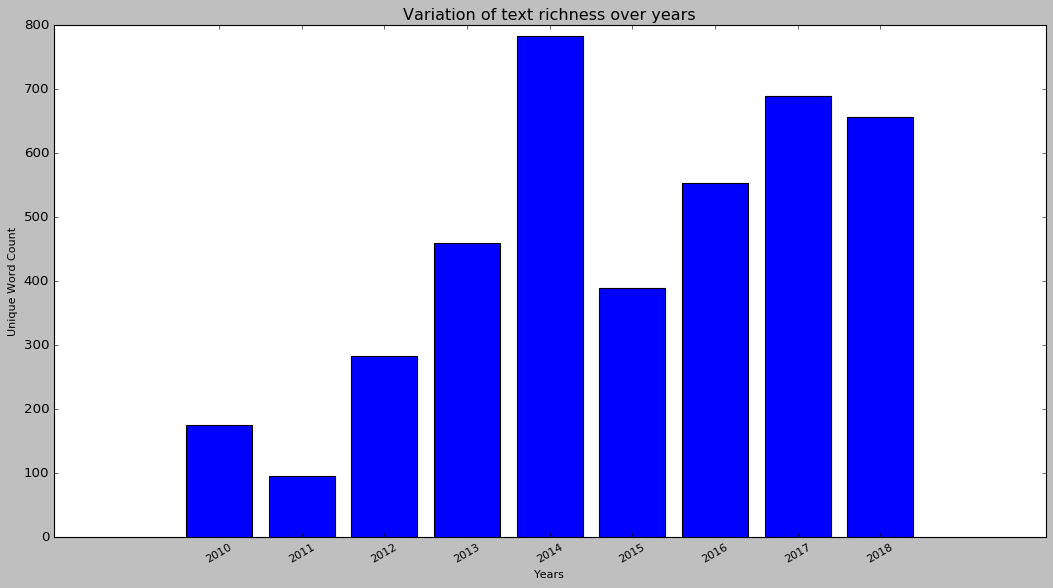

In [50]:
plot_bar_graph(cleaned[cleaned.state=='CA'].year.tolist(), cleaned[cleaned.state=='CA'].unique_word_count.tolist())

#### 3. Word Count - With Stop Words

In [27]:
from collections import Counter
def get_word_count(rev):
    count=Counter(rev)
    items=[(k,v) for k,v in count.items()]
    items.sort(key=lambda x: x[1], reverse=True)
    return items[:15]

# finding top 5 unique words
cleaned['word_frequency']=cleaned['review_token'].apply(get_word_count)

#### 3. Word Count - Without Stop Words

In [28]:
def remove_stop_words(text):
    stopwords = nltk.corpus.stopwords.words('english')
    return [w for w in text if w not in stopwords]

# removing stop words
cleaned['review_token_no_sw']=cleaned['review_token'].apply(remove_stop_words)

# finding top 5 unique words
cleaned['word_frequency_no_sw']=cleaned['review_token_no_sw'].apply(get_word_count)

In [29]:
for year,val in zip(cleaned[cleaned.state=='CA'].year.tolist(),cleaned[cleaned.state=='CA'].word_frequency_no_sw.tolist()):
    print("year - ",year," words -",val)

year -  2010  words - [('ist', 6), ('die', 6), ('man', 6), ('zu', 6), ('es', 5), ('der', 4), ('im', 4), ('nicht', 4), ('dem', 4), ('canyon', 4), ('geht', 4), ('ein', 3), ('und', 3), ('r', 3), ('den', 3)]
year -  2011  words - [('patricia', 5), ('body', 4), ('massages', 2), ('therapists', 2), ('found', 2), ('needed', 2), ('recommend', 2), ('physical', 2), ('understands', 2), ('heaven', 1), ('classic', 1), ('cars', 1), ('amazing', 1), ('music', 1), ('hot', 1)]
year -  2012  words - [('rockabilly', 7), ('vegas', 6), ('people', 6), ('weekend', 5), ('las', 5), ('music', 4), ('band', 4), ('every', 4), ('much', 4), ('fun', 4), ('great', 4), ('viva', 4), ('vlv', 4), ('dance', 4), ('love', 3)]
year -  2013  words - [('e', 9), ('year', 8), ('show', 7), ('di', 7), ('car', 6), ('great', 6), ('get', 5), ('rockabilly', 5), ('go', 5), ('love', 4), ('reverend', 4), ('martini', 4), ('stage', 4), ('even', 4), ('next', 4)]
year -  2014  words - [('one', 13), ('make', 11), ('class', 9), ('us', 9), ('vanes

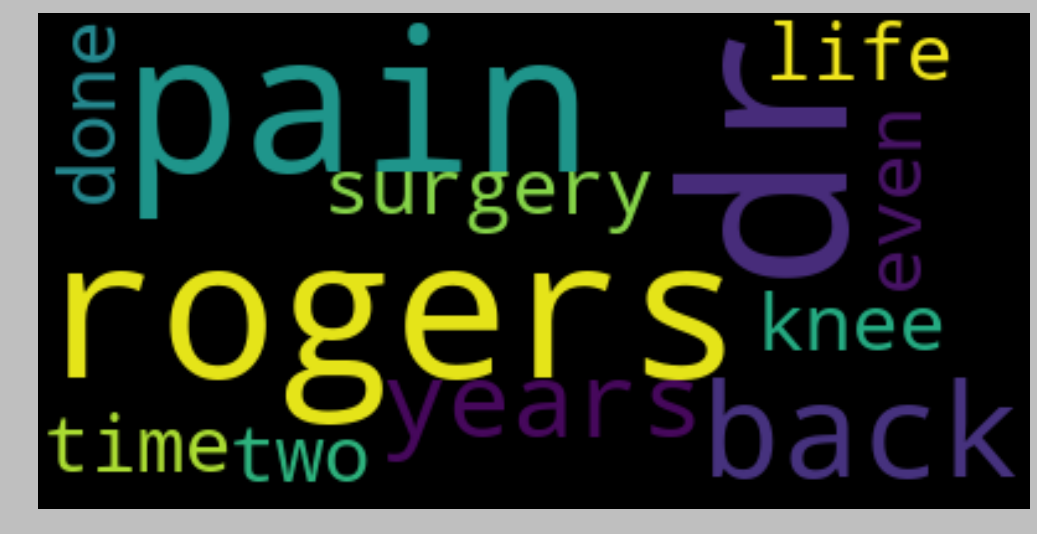

In [51]:
# generating word cloud for year 2018
gen_word_cloud(cleaned[cleaned.state=='CA'].word_frequency_no_sw.tolist()[-1])

#### 4. Complex words (len > 5)

In [31]:
cleaned['complex_words']=cleaned['review_token'].apply(lambda x: len([w for w in x if len(w)>5]))

In [55]:
def get_complex_word_pct(cleaned):
    # For Califronia    
    cleaned['complex_words_pct']=round((cleaned['complex_words']/cleaned['total_word_count'])*100,2)
    return cleaned

cleaned=cleaned.apply(get_complex_word_pct,axis=1)

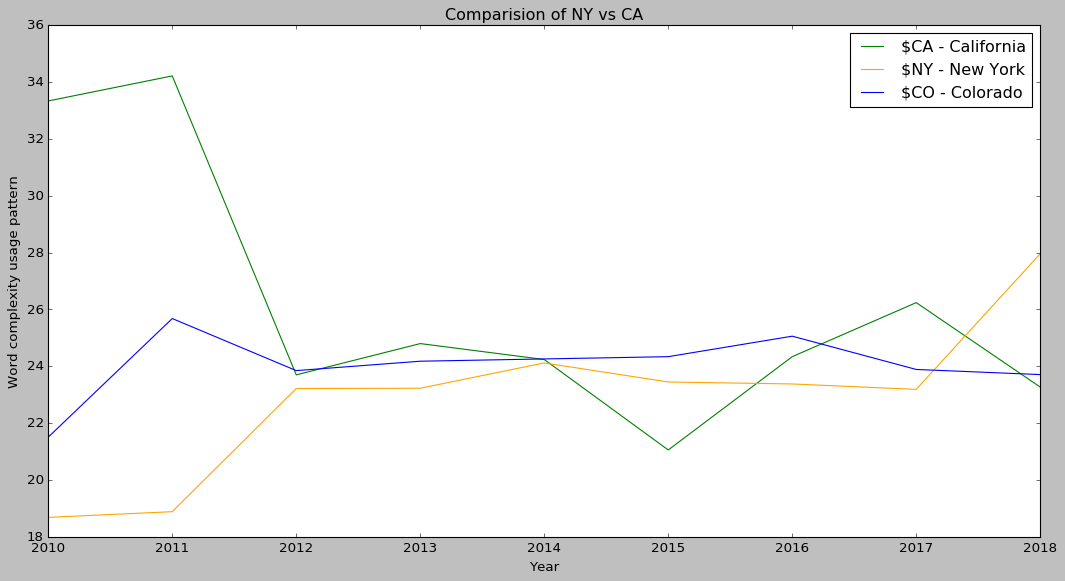

In [72]:
# comparing the usage of CA vs New York
year = cleaned[cleaned.state=='CA'].year.tolist()
NY=cleaned[cleaned.state=='NY'].complex_words_pct.tolist()[1:]
CA=cleaned[cleaned.state=='CA'].complex_words_pct.tolist()
CO = cleaned[cleaned.state=='CO'].complex_words_pct.tolist()[2:]

# generating the graph for each 
gen_bar_graph(year,CA, NY,CO,"Word complexity usage pattern")

#### 5. Part-Of-Speech Tagging 

In [35]:
# part of speech tagging
cleaned['review_token_pos'] = cleaned['review_token'].apply(lambda x: nltk.pos_tag(x))

In [36]:
def pos_identifier(text):
    # identifying top 5 POS count in reviews 
    pos_count={}
    for word,pos in text:
        if pos in pos_count.keys():
            pos_count[pos]+=1
        else:
            pos_count[pos]=1

    temp=[(i,j) for (i,j) in pos_count.items()]
    temp.sort(key=lambda x: x[1],reverse=True)

    return temp[:5]

In [37]:
cleaned['top_pos']=cleaned['review_token_pos'].apply(pos_identifier)

In [38]:
cleaned[cleaned.state=='CA'].top_pos.tolist()

[[('NN', 152), ('JJ', 43), ('VBP', 18), ('NNS', 11), ('IN', 6)],
 [('NN', 29), ('JJ', 19), ('IN', 16), ('NNS', 14), ('DT', 14)],
 [('NN', 110), ('DT', 64), ('JJ', 56), ('IN', 49), ('NNS', 40)],
 [('NN', 287), ('JJ', 81), ('DT', 76), ('IN', 76), ('NNS', 51)],
 [('NN', 409), ('JJ', 178), ('IN', 174), ('DT', 144), ('PRP', 124)],
 [('NN', 167), ('DT', 92), ('IN', 82), ('JJ', 67), ('RB', 50)],
 [('NN', 327), ('JJ', 102), ('IN', 94), ('DT', 88), ('RB', 85)],
 [('NN', 395), ('IN', 228), ('JJ', 175), ('DT', 160), ('PRP', 139)],
 [('NN', 370), ('IN', 204), ('JJ', 170), ('RB', 143), ('DT', 142)]]

In [39]:
cleaned[cleaned.state=='NY'].top_pos.tolist()

[[('NN', 116), ('IN', 57), ('DT', 53), ('JJ', 49), ('RB', 37)],
 [('NN', 128), ('JJ', 74), ('DT', 66), ('IN', 58), ('RB', 58)],
 [('NN', 88), ('JJ', 46), ('DT', 41), ('IN', 40), ('PRP', 28)],
 [('NN', 451), ('IN', 235), ('JJ', 231), ('DT', 223), ('RB', 155)],
 [('NN', 437), ('DT', 214), ('JJ', 208), ('IN', 203), ('RB', 120)],
 [('NN', 427), ('IN', 206), ('DT', 198), ('JJ', 165), ('RB', 152)],
 [('NN', 686), ('IN', 376), ('DT', 347), ('JJ', 295), ('RB', 246)],
 [('NN', 616), ('IN', 299), ('DT', 286), ('JJ', 282), ('RB', 174)],
 [('NN', 660), ('IN', 337), ('JJ', 304), ('DT', 290), ('RB', 231)],
 [('NN', 188), ('IN', 99), ('DT', 96), ('JJ', 72), ('RB', 62)]]

In [80]:
#print(nltk.pos_tag(nltk.word_tokenize("My first visit here to meet friends for lunch.  Nice ambience in downtown Sunnyvale and seems like a popular lunch hangout place.  Food is Pan Asian cuisine sort of like Indo-Chinese.")))

## Task 2: Information extraction - Aspect/Entity identification

I have the following pipeline for Information Extraction
- Sentence segmentation and tokenization
- Part of speech tagging of each token in the sentence
- Entity detection
- Relationship detection

In [40]:
def gen_noun_chunks(txt):
    #txt_pos=nltk.pos_tag(txt)
    #rev="doctor Rathi is great but his staff is bad"
    #t=nltk.word_tokenize(rev)
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    chunk_parser = nltk.RegexpParser(grammar)
    tree=chunk_parser.parse(txt)
    return pick_noun_phrase(tree)

def pick_noun_phrase(tree):
    #print(tree)
    noun_phrases=list()
    for j in [i for i in tree]:
        try: 
            if j.label()=='NP':
                np=" ".join([i[0] for i in j])
                #print(np)
                noun_phrases.append(np)
                #print(noun_phrases)
        except:
            continue
    return [i for i in set(noun_phrases) if len(i)>3]
    # return only if each total character

# Identifying aspects in the reviews
cleaned['aspects'] = cleaned['review_token_pos'].apply(gen_noun_chunks)    

## Task 3: Named Entity Recognition
- PERSON	People, including fictional.
- NORP	Nationalities or religious or political groups.
- FAC	Buildings, airports, highways, bridges, etc.
- ORG	Companies, agencies, institutions, etc.
- GPE	Countries, cities, states.
- LOC	Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT	Objects, vehicles, foods, etc. (Not services.)

In [41]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.max_length=3000000

In [44]:
def gen_entity(rev):   
    if len(rev)>250000:
        return (0,0)
    entity=[]
    count=dict()
    # document in spacy format
    doc=nlp(" ".join(rev))
    # looking through the corpus
    for X in doc.ents:
        # if X.label_ in entities:
        entity.append((X.label_,X.text))
        if X.label_ in count.keys():
            count[X.label_]+=1
        else:
            count[X.label_]=1
       # generate the counter
    return (entity,count)

def get_entity(row):
    entity,count=gen_entity(row['review_token'])
    row['entity']=entity
    row['entity_count']=count
    return row

In [45]:
# Identify the 
cleaned=cleaned.apply(get_entity,axis=1)

In [54]:
cleaned.to_csv("yelp_reviews_corpus.csv")

In [122]:
# visualizing entity relations
displacy.render(nlp(" ".join(cleaned[cleaned.state=='NY'].review_token.tolist()[3][20:30])), style='dep', jupyter = True, options = {'distance': 120})

In [118]:
# visualizing entities in the sentence
viz=nlp(" ".join(cleaned[cleaned.state=='NY'].review_token.tolist()[3]))
displacy.render(viz,style='ent',jupyter=True)